In [1]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import itertools

In [3]:
# Desired resolution (modify as needed)
desired_res = (32, 32, 32)

hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 0,  # Number of epochs between learning rate decay
    'decay_epoch': 25,
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
num_epochs = 50
print_every = 1
# in_channels, out_channels, kernel_size, stride, padding
# stages = [
#     [(1, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
#     # [(32, 64, 5, 1, 1), (64, 64, 5, 1, 1), (64, 64, 5, 1, 1)]
# ]
# stages = [
#        [(1, 16, 3, 1, 1), (16, 16, 3, 1, 1)],  # Fewer channels
#     [(16, 32, 5, 1, 1), (32, 32, 5, 1, 1)]
# ]
# pooling_configs = [
#     (2, 2, 1),  # Pooling after the first stage
#     # (2, 2, 1)      # No pooling after the third stage
# ]
stages = [
    [(1, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
    [(32, 64, 5, 1, 1), (64, 64, 5, 1, 1), (64, 64, 5, 1, 1)]
]

# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    (2, 2, 1)      # No pooling after the third stage
]
# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding


In [4]:
import os
print(os.listdir('../'))

['DATA', 'everything_with_models', '4foils_L270_0.05_50_64x64x64_v2', 'best_models', '4foils_L270_0.15_450_64x64x64_v10', '4foils_L270_0.15_50_64x64x64_v1', '4foils_L270_0.25_50_64x64x64_v1', 'HOPFS_L270_0.05_100_64x64x64_v1', 'HOPFS_L270_0.05_1000_64x64x64_v1', 'my_functions', 'HOPFS_L270_0.25_100_64x64x64_v1', '4foils_L270_0.05_50_64x64x64_v1', '4foils_L270_0.25_450_64x64x64_v1', '4foils_L270_0.05_450_64x64x64_v1', 'ML_ipynb', 'fix_names_folders.py', 'HOPFS_L270_0.25_1000_64x64x64_v1', '4foils_L270_0.15_50_64x64x64_v2', '4foils_L270_0.25_50_64x64x64_v2', '4foils_L270_0.15_450_64x64x64_v1', 'classification_spectrum_tunning', 'HOPFS_L270_0.15_1000_64x64x64_v1', 'HOPFS_L270_0.15_100_64x64x64_v1', 'classification_knots_tunning', 'functions', 'models_full_train', 'data_generation']


In [5]:

foils = list(itertools.product(range(3), repeat=4))
foils = foils[:]
knots = [''.join([str(element) for element in foil]) for foil in foils]
knot_types = {
    knot : it for it, knot in enumerate(knots)
}

# folder = '../DATA/HOPFS_L270_5e-07_test_1s'
# folder = '../HOPFS_L270_5e-07_test_1s'
# List of folders to search for data
folders = [
    '../4foils_L270_0.15_50_64x64x64_v1',
    '../4foils_L270_0.05_50_64x64x64_v1',
    '../4foils_L270_0.25_50_64x64x64_v1',
    '../4foils_L270_0.15_450_64x64x64_v1',
    '../4foils_L270_0.05_450_64x64x64_v1',
    '../4foils_L270_0.25_450_64x64x64_v1'
]
# folders = [
#     '../4foils_L270_0.05_1_64x64x64_v1',
# ]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True


# Loop through all folders and knots
for folder in folders:
    for knot in knots:
        filename = f'{folder}/data_{knot}.csv'
        try:
            with open(filename, 'r') as file:
                reader = csv.reader(file)
                for row in reader:
                    # Deserialize the JSON string back to a list
                    data_list = json.loads(row[0])
                    data_array = np.array(data_list)

                    # Extract points and dimensions
                    points_list = data_array[2:]
                    Nx, Ny, Nz = data_array[1]

                    if flag_print_shape:
                        print(f'Shape: {Nx}, {Ny}, {Nz}')
                        flag_print_shape = False

                    # Rescale if necessary
                    if desired_res != (Nx, Ny, Nz):
                        scale_x = desired_res[0] / Nx
                        scale_y = desired_res[1] / Ny
                        scale_z = desired_res[2] / Nz
                        points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

                    # Initialize a 3D array and set points to 1
                    dots_3d = np.zeros(desired_res, dtype=int)
                    for x, y, z in points_list:
                        try:
                            dots_3d[x, y, z] = 1
                        except IndexError:
                            continue

                    # Append to lists
                    X_list.append(dots_3d)
                    Y_list.append(knot_types[knot])

        except FileNotFoundError:
            print(f'File not found: {filename}')
        except json.JSONDecodeError:
            print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Shape: 64, 64, 64
Loaded 121500 samples.  1500 per class


In [6]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
# print(X_np)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)

torch.Size([121500, 1, 32, 32, 32]) torch.Size([121500, 81])


In [7]:

train_dataset = TensorDataset(X_torch, y_torch)

In [8]:
def conv_stage(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)

def create_pooling_layer(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool3d(kernel_size=kernel_size, stride=stride, padding=padding)

class Classifier3D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11):
        super(Classifier3D, self).__init__()

        self.features = nn.Sequential()
        self.desired = desired_res

        for i, stage in enumerate(stages):
            # Add the convolutional stage
            self.features.add_module(f"stage_{i}", conv_stage(stage))

            # Add a custom MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)


        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, *self.desired))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        # self.fc2 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x


In [9]:


model = Classifier3D(stages, pooling_configs, num_classes=len(knots)).to(device)
model.initialize_weights()

In [10]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:2][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch))
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([1, 1, 32, 32, 32])
tensor([[ 0.2040, -0.0125,  0.2196, -0.3231, -0.1574, -0.0471,  0.1128, -0.1368,
          0.2669,  0.0449, -0.3340, -0.1490, -0.1815,  0.2740,  0.3485, -0.0051,
          0.1290,  0.1406, -0.1675, -0.1674,  0.1359,  0.1429,  0.0243,  0.0074,
         -0.1841,  0.1663, -0.1887, -0.0142,  0.1787, -0.1360,  0.1176,  0.1803,
         -0.2244,  0.1907, -0.3227,  0.0788,  0.0007,  0.0170,  0.1028, -0.0376,
         -0.1588, -0.1037,  0.1757, -0.0049,  0.0500,  0.1337,  0.0470,  0.2100,
         -0.1002, -0.1159, -0.2434,  0.0977, -0.1202,  0.1552, -0.0054,  0.0069,
          0.0272,  0.1891, -0.0538,  0.2027,  0.1186,  0.1980, -0.2880, -0.1249,
          0.0027,  0.0878, -0.3124, -0.2126, -0.1327, -0.0597, -0.0241,  0.0181,
         -0.0312,  0.0678,  0.0084,  0.1591,  0.1596,  0.0074,  0.0899, -0.1758,
          0.0641]], device='cuda:0', grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)           

In [11]:
from torch.cuda.amp import autocast, GradScaler

# Initialize the GradScaler for mixed precision
scaler = GradScaler()

def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
         # Use autocast for mixed precision
        with autocast():
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
        
        # Scale the loss for numerical stability during backward pass
        scaler.scale(loss).backward()  # Backward pass
        
        # Step the optimizer using the scaled gradients
        scaler.step(optimizer)
        scaler.update()  # Update the scaler for next iteration

        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [12]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)


train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
# test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
scheduler.step(-1)
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(0)

    if epoch == hyperparams['decay_epoch'] -1:
        scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')


Progress:   2%|█▍                                                                     | 1/50 [06:11<5:03:25, 371.55s/it]

Epoch 0 completed in 371.55 seconds
Epoch 0: Train Loss: 2.5428, Val Loss: 0.0000


Progress:   4%|██▊                                                                    | 2/50 [12:22<4:57:07, 371.41s/it]

Epoch 1 completed in 371.31 seconds
Epoch 1: Train Loss: 1.2384, Val Loss: 0.0000


Progress:   6%|████▎                                                                  | 3/50 [18:34<4:50:52, 371.34s/it]

Epoch 2 completed in 371.25 seconds
Epoch 2: Train Loss: 1.0387, Val Loss: 0.0000


Progress:   8%|█████▋                                                                 | 4/50 [24:45<4:44:41, 371.33s/it]

Epoch 3 completed in 371.33 seconds
Epoch 3: Train Loss: 0.9509, Val Loss: 0.0000


Progress:  10%|███████                                                                | 5/50 [30:56<4:38:30, 371.33s/it]

Epoch 4 completed in 371.33 seconds
Epoch 4: Train Loss: 0.8965, Val Loss: 0.0000


Progress:  12%|████████▌                                                              | 6/50 [34:59<4:00:13, 327.57s/it]

Epoch 5 completed in 242.62 seconds
Epoch 5: Train Loss: 0.8576, Val Loss: 0.0000


Progress:  14%|█████████▉                                                             | 7/50 [37:56<3:19:35, 278.49s/it]

Epoch 6 completed in 177.44 seconds
Epoch 6: Train Loss: 0.8237, Val Loss: 0.0000


Progress:  16%|███████████▎                                                           | 8/50 [40:54<2:52:24, 246.30s/it]

Epoch 7 completed in 177.37 seconds
Epoch 7: Train Loss: 0.7956, Val Loss: 0.0000


Progress:  18%|████████████▊                                                          | 9/50 [43:51<2:33:34, 224.73s/it]

Epoch 8 completed in 177.31 seconds
Epoch 8: Train Loss: 0.7698, Val Loss: 0.0000


Progress:  20%|██████████████                                                        | 10/50 [46:48<2:20:03, 210.08s/it]

Epoch 9 completed in 177.27 seconds
Epoch 9: Train Loss: 0.7495, Val Loss: 0.0000


Progress:  22%|███████████████▍                                                      | 11/50 [49:46<2:10:02, 200.06s/it]

Epoch 10 completed in 177.35 seconds
Epoch 10: Train Loss: 0.7288, Val Loss: 0.0000


Progress:  24%|████████████████▊                                                     | 12/50 [52:43<2:02:20, 193.17s/it]

Epoch 11 completed in 177.42 seconds
Epoch 11: Train Loss: 0.7107, Val Loss: 0.0000


Progress:  26%|██████████████████▏                                                   | 13/50 [55:41<1:56:12, 188.44s/it]

Epoch 12 completed in 177.55 seconds
Epoch 12: Train Loss: 0.6925, Val Loss: 0.0000


Progress:  28%|███████████████████▌                                                  | 14/50 [58:38<1:51:03, 185.10s/it]

Epoch 13 completed in 177.38 seconds
Epoch 13: Train Loss: 0.6767, Val Loss: 0.0000


Progress:  30%|████████████████████▍                                               | 15/50 [1:01:35<1:46:35, 182.74s/it]

Epoch 14 completed in 177.26 seconds
Epoch 14: Train Loss: 0.6597, Val Loss: 0.0000


Progress:  32%|█████████████████████▊                                              | 16/50 [1:04:33<1:42:37, 181.10s/it]

Epoch 15 completed in 177.30 seconds
Epoch 15: Train Loss: 0.6431, Val Loss: 0.0000


Progress:  34%|███████████████████████                                             | 17/50 [1:07:30<1:38:59, 179.98s/it]

Epoch 16 completed in 177.36 seconds
Epoch 16: Train Loss: 0.6297, Val Loss: 0.0000


Progress:  36%|████████████████████████▍                                           | 18/50 [1:10:27<1:35:34, 179.20s/it]

Epoch 17 completed in 177.37 seconds
Epoch 17: Train Loss: 0.6152, Val Loss: 0.0000


Progress:  38%|█████████████████████████▊                                          | 19/50 [1:13:25<1:32:19, 178.68s/it]

Epoch 18 completed in 177.48 seconds
Epoch 18: Train Loss: 0.6001, Val Loss: 0.0000


Progress:  40%|███████████████████████████▏                                        | 20/50 [1:16:22<1:29:08, 178.30s/it]

Epoch 19 completed in 177.41 seconds
Epoch 19: Train Loss: 0.5866, Val Loss: 0.0000


Progress:  42%|████████████████████████████▌                                       | 21/50 [1:19:20<1:26:02, 178.01s/it]

Epoch 20 completed in 177.34 seconds
Epoch 20: Train Loss: 0.5719, Val Loss: 0.0000


Progress:  44%|█████████████████████████████▉                                      | 22/50 [1:22:17<1:22:58, 177.81s/it]

Epoch 21 completed in 177.32 seconds
Epoch 21: Train Loss: 0.5568, Val Loss: 0.0000


Progress:  46%|███████████████████████████████▎                                    | 23/50 [1:25:14<1:19:57, 177.69s/it]

Epoch 22 completed in 177.41 seconds
Epoch 22: Train Loss: 0.5441, Val Loss: 0.0000


Progress:  48%|████████████████████████████████▋                                   | 24/50 [1:28:12<1:16:57, 177.59s/it]

Epoch 23 completed in 177.37 seconds
Epoch 23: Train Loss: 0.5303, Val Loss: 0.0000


Progress:  50%|██████████████████████████████████                                  | 25/50 [1:31:09<1:13:58, 177.55s/it]

Epoch 00002: reducing learning rate of group 0 to 2.0000e-06.
Epoch 24 completed in 177.47 seconds
Epoch 24: Train Loss: 0.5171, Val Loss: 0.0000


Progress:  52%|███████████████████████████████████▎                                | 26/50 [1:34:07<1:11:00, 177.52s/it]

Epoch 25 completed in 177.43 seconds
Epoch 25: Train Loss: 0.4725, Val Loss: 0.0000


Progress:  54%|████████████████████████████████████▋                               | 27/50 [1:37:04<1:08:01, 177.47s/it]

Epoch 26 completed in 177.35 seconds
Epoch 26: Train Loss: 0.4666, Val Loss: 0.0000


Progress:  56%|██████████████████████████████████████                              | 28/50 [1:40:01<1:05:02, 177.40s/it]

Epoch 27 completed in 177.23 seconds
Epoch 27: Train Loss: 0.4626, Val Loss: 0.0000


Progress:  58%|███████████████████████████████████████▍                            | 29/50 [1:42:58<1:02:04, 177.37s/it]

Epoch 28 completed in 177.29 seconds
Epoch 28: Train Loss: 0.4598, Val Loss: 0.0000


Progress:  60%|██████████████████████████████████████████                            | 30/50 [1:45:56<59:06, 177.34s/it]

Epoch 29 completed in 177.28 seconds
Epoch 29: Train Loss: 0.4566, Val Loss: 0.0000


Progress:  62%|███████████████████████████████████████████▍                          | 31/50 [1:48:53<56:09, 177.35s/it]

Epoch 30 completed in 177.38 seconds
Epoch 30: Train Loss: 0.4524, Val Loss: 0.0000


Progress:  64%|████████████████████████████████████████████▊                         | 32/50 [1:51:51<53:12, 177.39s/it]

Epoch 31 completed in 177.47 seconds
Epoch 31: Train Loss: 0.4494, Val Loss: 0.0000


Progress:  66%|██████████████████████████████████████████████▏                       | 33/50 [1:54:48<50:16, 177.44s/it]

Epoch 32 completed in 177.54 seconds
Epoch 32: Train Loss: 0.4460, Val Loss: 0.0000


Progress:  68%|███████████████████████████████████████████████▌                      | 34/50 [1:57:46<47:18, 177.44s/it]

Epoch 33 completed in 177.44 seconds
Epoch 33: Train Loss: 0.4427, Val Loss: 0.0000


Progress:  70%|█████████████████████████████████████████████████                     | 35/50 [2:00:43<44:21, 177.43s/it]

Epoch 34 completed in 177.43 seconds
Epoch 34: Train Loss: 0.4398, Val Loss: 0.0000


Progress:  72%|██████████████████████████████████████████████████▍                   | 36/50 [2:03:40<41:23, 177.42s/it]

Epoch 35 completed in 177.39 seconds
Epoch 35: Train Loss: 0.4362, Val Loss: 0.0000


Progress:  74%|███████████████████████████████████████████████████▊                  | 37/50 [2:06:38<38:25, 177.37s/it]

Epoch 36 completed in 177.24 seconds
Epoch 36: Train Loss: 0.4336, Val Loss: 0.0000


Progress:  76%|█████████████████████████████████████████████████████▏                | 38/50 [2:09:35<35:28, 177.35s/it]

Epoch 37 completed in 177.32 seconds
Epoch 37: Train Loss: 0.4295, Val Loss: 0.0000


Progress:  78%|██████████████████████████████████████████████████████▌               | 39/50 [2:12:32<32:31, 177.38s/it]

Epoch 38 completed in 177.44 seconds
Epoch 38: Train Loss: 0.4263, Val Loss: 0.0000


Progress:  80%|████████████████████████████████████████████████████████              | 40/50 [2:15:30<29:34, 177.42s/it]

Epoch 39 completed in 177.51 seconds
Epoch 39: Train Loss: 0.4235, Val Loss: 0.0000


Progress:  82%|█████████████████████████████████████████████████████████▍            | 41/50 [2:18:27<26:36, 177.42s/it]

Epoch 40 completed in 177.41 seconds
Epoch 40: Train Loss: 0.4201, Val Loss: 0.0000


Progress:  84%|██████████████████████████████████████████████████████████▊           | 42/50 [2:21:25<23:39, 177.41s/it]

Epoch 41 completed in 177.41 seconds
Epoch 41: Train Loss: 0.4166, Val Loss: 0.0000


Progress:  86%|████████████████████████████████████████████████████████████▏         | 43/50 [2:24:22<20:41, 177.42s/it]

Epoch 42 completed in 177.45 seconds
Epoch 42: Train Loss: 0.4139, Val Loss: 0.0000


Progress:  88%|█████████████████████████████████████████████████████████████▌        | 44/50 [2:27:20<17:44, 177.43s/it]

Epoch 43 completed in 177.44 seconds
Epoch 43: Train Loss: 0.4109, Val Loss: 0.0000


Progress:  90%|███████████████████████████████████████████████████████████████       | 45/50 [2:30:17<14:47, 177.41s/it]

Epoch 44 completed in 177.35 seconds
Epoch 44: Train Loss: 0.4066, Val Loss: 0.0000


Progress:  92%|████████████████████████████████████████████████████████████████▍     | 46/50 [2:33:14<11:49, 177.40s/it]

Epoch 45 completed in 177.39 seconds
Epoch 45: Train Loss: 0.4040, Val Loss: 0.0000


Progress:  94%|█████████████████████████████████████████████████████████████████▊    | 47/50 [2:36:12<08:52, 177.40s/it]

Epoch 46 completed in 177.40 seconds
Epoch 46: Train Loss: 0.4008, Val Loss: 0.0000


Progress:  96%|███████████████████████████████████████████████████████████████████▏  | 48/50 [2:39:09<05:54, 177.41s/it]

Epoch 47 completed in 177.43 seconds
Epoch 47: Train Loss: 0.3979, Val Loss: 0.0000


Progress:  98%|████████████████████████████████████████████████████████████████████▌ | 49/50 [2:42:07<02:57, 177.40s/it]

Epoch 48 completed in 177.39 seconds
Epoch 48: Train Loss: 0.3949, Val Loss: 0.0000


Progress: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [2:45:04<00:00, 198.09s/it]

Epoch 49 completed in 177.39 seconds
Epoch 49: Train Loss: 0.3915, Val Loss: 0.0000
Total training time: 9904.42 seconds


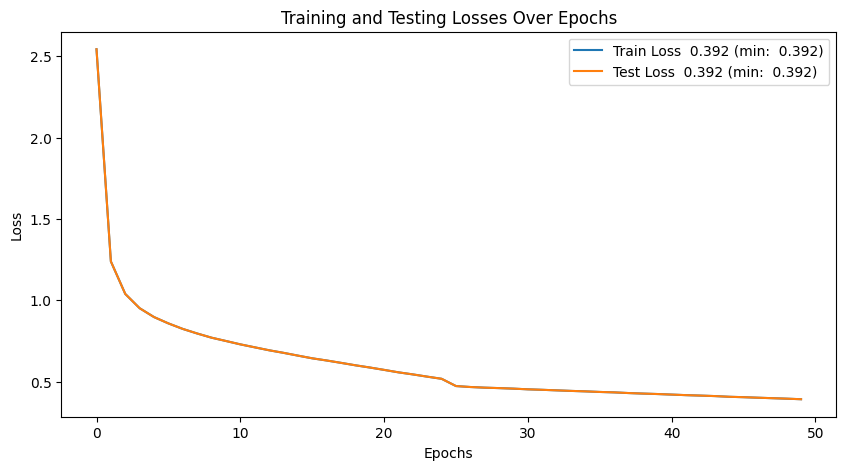

In [13]:
plot_losses(train_losses, train_losses, decimals=3)

In [14]:
# Save the model state (weights) and structure
model_save_path = "classifier_4foil_3d_full_2.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparams': hyperparams,
    'num_classes': num_classes,
    'stages': stages,
    'pooling_configs': pooling_configs,
    'desired_res': desired_res,
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to classifier_4foil_3d_full_2.pth
